In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, RobustScaler, StandardScaler, MinMaxScaler
import pandas as pd

## PART II: Introducing Real Data

Now, we will apply the whole analysis that we just implemented for the case of the Franke function, including both regression methods in combination with every resampling technique, but using the real data that we obtain from the Boston Housing dataset. This dataset contains information about 12 different features regarding housing in Boston, and its retrieved from the SciKit-learn database, as shown below. The dataset also contains a target, called MEDV, which is the parameter that we aim to predict using our regression methods. Our goal is to find the best performing model between all of our combinations.

In [2]:
from sklearn.datasets import load_boston

boston_data = load_boston()
boston_df = pd.DataFrame(boston_data.data, columns=boston_data.feature_names)
boston_df['MEDV'] = boston_data.target

The following heatmap illustrates the correllation between each pair of the different 13 features of our dataset. With this information, we can make two considerations in order to simplify our data analysis:

1. There are three features that have a correlation with our target value of 33% or less, namely "CHAS", "DIS" and "B". Therefore, we can discard them from our analysis, as their usefulness will not be as big as the computational complexity they add to the analysis.

2. The features "AGE" and "RAD" have the same correlation value with our target. Thus, as they give us the same information regarding our analysis, we discard one of them ("RAD") to again reduce the complexity of our problem.

Following these considerations, we have reduced the number of degrees of freedom in our problem from 13 to 9, in principle without losing much accuracy. The full and reduced data collections are shown in the tables below the heatmap.

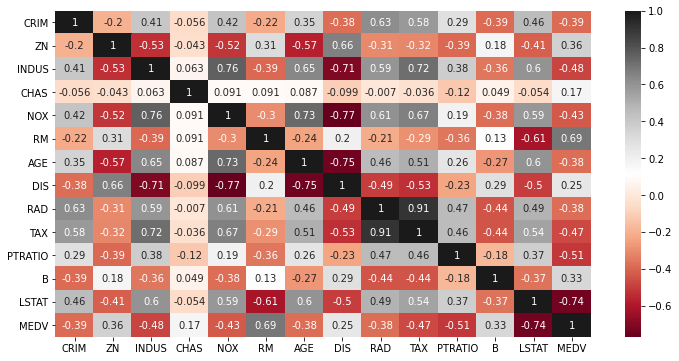

In [3]:
import seaborn as sns
corr_matrix = boston_df.corr().round(3)
fig3 =  plt.subplots(figsize=(12,6))
sns.heatmap(data=corr_matrix, annot=True, cmap = 'RdGy')
plt.show()

In [4]:
boston_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [5]:
X = boston_df.copy()
X.drop(['CHAS', 'DIS','B','RAD','MEDV'], axis='columns', inplace=True)
y = boston_df['MEDV']

In [6]:
X

,CRIM,ZN,INDUS,NOX,RM,AGE,TAX,PTRATIO,LSTAT
0,0.00632,18.0,2.31,0.538,6.575,65.2,296.0,15.3,4.98
1,0.02731,0.0,7.07,0.469,6.421,78.9,242.0,17.8,9.14
2,0.02729,0.0,7.07,0.469,7.185,61.1,242.0,17.8,4.03
3,0.03237,0.0,2.18,0.458,6.998,45.8,222.0,18.7,2.94
4,0.06905,0.0,2.18,0.458,7.147,54.2,222.0,18.7,5.33
...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.573,6.593,69.1,273.0,21.0,9.67
502,0.04527,0.0,11.93,0.573,6.120,76.7,273.0,21.0,9.08
503,0.06076,0.0,11.93,0.573,6.976,91.0,273.0,21.0,5.64
504,0.10959,0.0,11.93,0.573,6.794,89.3,273.0,21.0,6.48


The following two classes, where the regression methods are implemented, are analogous as the ones used in Part I of this project, only oriented to the use of our real dataset.

In [7]:
def DesignMatrix(degree,X):
    poly = PolynomialFeatures(degree = degree)
    X_pol = poly.fit_transform(X)
    sc = Normalizer().fit(X_pol)
    #sc = StandardScaler().fit(X_pol)
    #sc = MinMaxScaler(feature_range=(0, 10)).fit(X_pol)
    #sc = RobustScaler().fit(X_pol)
    X_sc = sc.transform(X_pol)
    
    return X_sc

In [8]:
class Regressor:
    
    def __init__(self,regressor, X_train, X_test, z_train, z_test, lambd = 0):
        self.X_train = X_train
        self.X_test = X_test
        self.z_train = z_train
        self.z_test = z_test
        self.lambd = lambd
        
        if(regressor == 'OLS'):
            self.beta = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(z_train)
        elif(regressor == 'Ridge'):
            self.beta = np.linalg.inv(X_train.T.dot(X_train)+lambd*np.identity(X_train.shape[1])).dot(X_train.T).dot(z_train)
        else:
            raise Exception("Only OLS or Ridge are valid inputs for regressor")
        self.z_pred_train = X_train.dot(self.beta)
        self.z_pred_test = X_test.dot(self.beta)
        
    def MSE_train(self):
        return  mean_squared_error(self.z_train, self.z_pred_train)
    
    def MSE_test(self):
        return  mean_squared_error(self.z_test, self.z_pred_test)
    
    def r2score_train(self):
        return  r2_score(self.z_train, self.z_pred_train)
    
    def r2score_test(self):
        return  r2_score(self.z_test, self.z_pred_test)
    
    def covariance_beta(self,sigma=1):
        if(self.regressor == 'OLS'):
            return sigma**2*np.linalg.inv(self.X_train.T.dot(self.X_train))
        elif(self.regressor == 'Ridge'):
            return sigma**2*np.linalg.inv(self.X_train.T.dot(self.X_train)+self.lambd*np.identity(self.X_train.shape[1]))

Both regression methods in combination with every resampling technique is now implemented. The individual results are presented but not discussed, as the conclusions we can draw from them are analogous to the ones discussed in Part I of this project.

### OLS regression (with polynomial degree 1-3)

#### No resampling

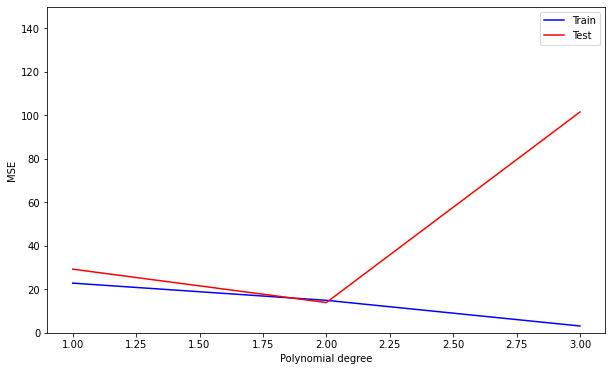

In [9]:
pol = 3

MSE_test_pol = []
MSE_train_pol = []
R2_test_pol = []
R2_train_pol = []


for deg in range(1,pol+1):
    X_matrix = DesignMatrix(deg, X)
    X_train, X_test, y_train, y_test = train_test_split(X_matrix, y, train_size=0.7)
    OLS = Regressor("OLS", X_train, X_test, y_train, y_test)
    
    MSE_test_pol.append(OLS.MSE_test())
    MSE_train_pol.append(OLS.MSE_train())
    R2_test_pol.append(OLS.r2score_test())
    R2_train_pol.append(OLS.r2score_train())

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(range(1,pol+1),MSE_train_pol, color = 'blue', label = 'Train')
ax.plot(range(1,pol+1),MSE_test_pol, color = 'red', label = 'Test')
ax.set_ylim(0,150)
ax.set_xlabel('Polynomial degree')
ax.set_ylabel('MSE')
ax.legend()
plt.show()

#### Bootstrap resampling

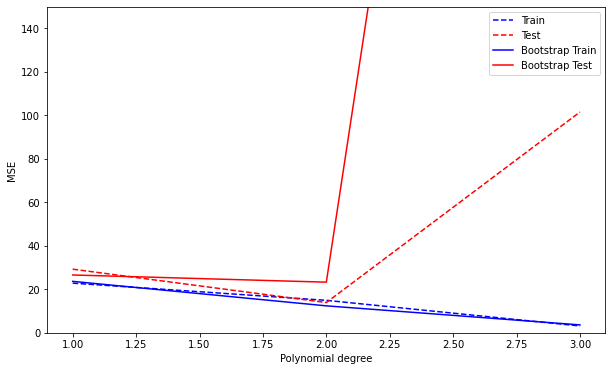

In [10]:
n_bootstrap = 100

MSE_test_pol_bootstrap = []
MSE_train_pol_bootstrap = []
R2_test_pol_bootstrap = []
R2_train_pol_bootstrap = []

for deg in range(1,pol+1):
    
    X_matrix = DesignMatrix(deg, X)
    MSE_tests_bootstrap = np.zeros(n_bootstrap)
    MSE_trains_bootstrap = np.zeros(n_bootstrap)
    r2_tests_bootstrap = np.zeros(n_bootstrap)
    r2_trains_bootstrap = np.zeros(n_bootstrap)
    
    for i in range(n_bootstrap):
        X_train, X_test, y_train, y_test = train_test_split(X_matrix, y, train_size=0.7)
        OLS = Regressor("OLS", X_train, X_test, y_train, y_test)

        MSE_tests_bootstrap[i] = OLS.MSE_test()
        MSE_trains_bootstrap[i] = OLS.MSE_train()

        r2_tests_bootstrap[i] = OLS.r2score_test()
        r2_trains_bootstrap[i] = OLS.r2score_train()

    MSE_test_pol_bootstrap.append(np.mean(MSE_tests_bootstrap))
    MSE_train_pol_bootstrap.append(np.mean(MSE_trains_bootstrap))
    R2_test_pol_bootstrap.append(np.mean(r2_tests_bootstrap))
    R2_train_pol_bootstrap.append(np.mean(r2_trains_bootstrap))


fig, ax = plt.subplots(figsize=(10,6))
ax.plot(range(1,pol+1),MSE_train_pol, "--", color = 'blue', label = 'Train')
ax.plot(range(1,pol+1),MSE_test_pol, "--", color = 'red', label = 'Test')
ax.plot(range(1,pol+1),MSE_train_pol_bootstrap, color = 'blue', label = 'Bootstrap Train')
ax.plot(range(1,pol+1),MSE_test_pol_bootstrap, color = 'red', label = 'Bootstrap Test')
ax.set_ylim(0,150)
ax.set_xlabel('Polynomial degree')
ax.set_ylabel('MSE')
ax.legend()
plt.show()

#### $k$-fold Cross-validation

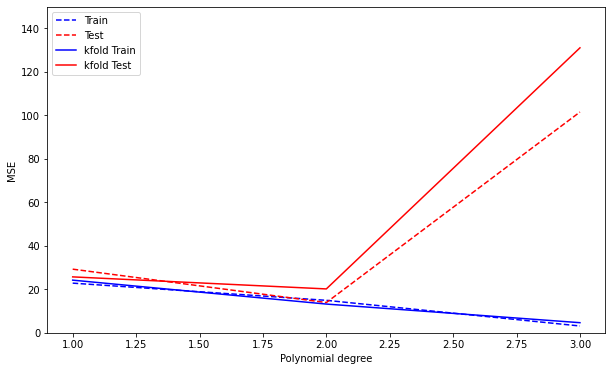

In [11]:
folds = 8
kf = KFold(n_splits=folds,shuffle=True)

MSE_test_pol_kfold = []
MSE_train_pol_kfold = []
r2_test_pol_kfold = []
r2_train_pol_kfold = []

y_cv = y
    
for deg in range(1,pol+1):
    
    X_cv = DesignMatrix(deg,X)
    
    MSE_tests_kfold = np.zeros(folds)
    MSE_trains_kfold = np.zeros(folds)
    r2_tests_kfold = np.zeros(folds)
    r2_trains_kfold = np.zeros(folds)
    
    itr = 0
    for train_i, test_i in kf.split(X_cv):

        X_train, X_test, y_train, y_test = X_cv[train_i], X_cv[test_i], y_cv[train_i], y_cv[test_i]
        OLS = Regressor("OLS", X_train, X_test, y_train, y_test)

        MSE_tests_kfold[itr] = OLS.MSE_test()
        MSE_trains_kfold[itr] = OLS.MSE_train()
        r2_tests_kfold[itr] = OLS.r2score_test()
        r2_trains_kfold[itr] = OLS.r2score_train()
        itr +=1

    MSE_test_pol_kfold.append( np.mean(MSE_tests_kfold) )
    MSE_train_pol_kfold.append( np.mean(MSE_trains_kfold) )
    r2_test_pol_kfold.append( np.mean(r2_tests_kfold) )
    r2_train_pol_kfold.append( np.mean(r2_trains_kfold) )

    
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(range(1,pol+1),MSE_train_pol, "--", color = 'blue', label = 'Train')
ax.plot(range(1,pol+1),MSE_test_pol, "--", color = 'red', label = 'Test')
ax.plot(range(1,pol+1),MSE_train_pol_kfold, color = 'blue', label = 'kfold Train')
ax.plot(range(1,pol+1),MSE_test_pol_kfold, color = 'red', label = 'kfold Test')
ax.set_ylim(0,150)
ax.set_xlabel('Polynomial degree')
ax.set_ylabel('MSE')
ax.legend()
plt.show()

#### OLS: no resampling vs bootstrap vs cross-validation

In [12]:
print("MSE (no resampling):", np.round(MSE_test_pol[1],3) )
print("R2 score (no resampling):", np.round(R2_test_pol[1],3), "\n")  

print("MSE (bootstrap):", np.round(MSE_test_pol_bootstrap[1],3) )
print("R2 score (bootstrap):", np.round(R2_test_pol_bootstrap[1],3), "\n")  

print("MSE (kfold):", np.round(MSE_test_pol_kfold[1],3) )
print("R2 score (kfold):", np.round(r2_test_pol_kfold[1],3) )  

MSE (no resampling): 13.91
R2 score (no resampling): 0.805 

MSE (bootstrap): 23.287
R2 score (bootstrap): 0.722 

MSE (kfold): 20.18
R2 score (kfold): 0.757


### Ridge regression

#### No resampling

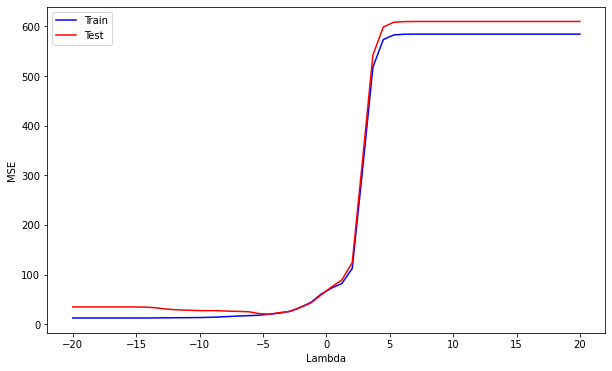

In [13]:
lambd = np.logspace(-20, 20, 50)

MSE_test_lambda = []
MSE_train_lambda = []
R2_test_lambda = []
R2_train_lambda = []

X_matrix = DesignMatrix(2, X)
X_train, X_test, y_train, y_test = train_test_split(X_matrix, y, train_size=0.7)

for L in lambd:
    Ridge = Regressor("Ridge", X_train, X_test, y_train, y_test, L)
    
    MSE_test_lambda.append(Ridge.MSE_test())
    MSE_train_lambda.append(Ridge.MSE_train())
    R2_test_lambda.append(Ridge.r2score_test())
    R2_train_lambda.append(Ridge.r2score_train())

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(np.log10(lambd),MSE_train_lambda, color = 'blue', label = 'Train')
ax.plot(np.log10(lambd),MSE_test_lambda, color = 'red', label = 'Test')
ax.set_xlabel('Lambda')
ax.set_ylabel('MSE')
ax.legend()
plt.show()

#### Bootstrap resampling

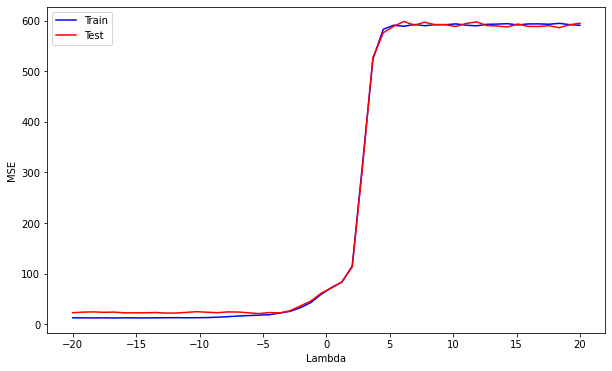

In [14]:
lambd = np.logspace(-20, 20, 50)
n_bootstrap = 100

MSE_test_lambda_bootstrap = []
MSE_train_lambda_bootstrap = []
R2_test_lambda_bootstrap = []
R2_train_lambda_bootstrap = []

X_matrix = DesignMatrix(2, X)

for L in lambd:
     
    MSE_tests_bootstrap = np.zeros(n_bootstrap)
    MSE_trains_bootstrap = np.zeros(n_bootstrap)
    r2_tests_bootstrap = np.zeros(n_bootstrap)
    r2_trains_bootstrap = np.zeros(n_bootstrap)
    
    for i in range(n_bootstrap):
        
        X_train, X_test, y_train, y_test = train_test_split(X_matrix, y, train_size=0.7)
        Ridge = Regressor("Ridge", X_train, X_test, y_train, y_test, L)

        MSE_tests_bootstrap[i] = Ridge.MSE_test()
        MSE_trains_bootstrap[i] = Ridge.MSE_train()

        r2_tests_bootstrap[i] = Ridge.r2score_test()
        r2_trains_bootstrap[i] = Ridge.r2score_train()
    
    MSE_test_lambda_bootstrap.append(np.mean(MSE_tests_bootstrap))
    MSE_train_lambda_bootstrap.append(np.mean(MSE_trains_bootstrap))
    R2_test_lambda_bootstrap.append(np.mean(r2_tests_bootstrap))
    R2_train_lambda_bootstrap.append(np.mean(r2_trains_bootstrap))
    
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(np.log10(lambd), MSE_train_lambda_bootstrap, color = 'blue', label = 'Train')
ax.plot(np.log10(lambd), MSE_test_lambda_bootstrap, color = 'red', label = 'Test')
ax.set_xlabel('Lambda')
ax.set_ylabel('MSE')
ax.legend()
plt.show()

#### Cross-validation resampling

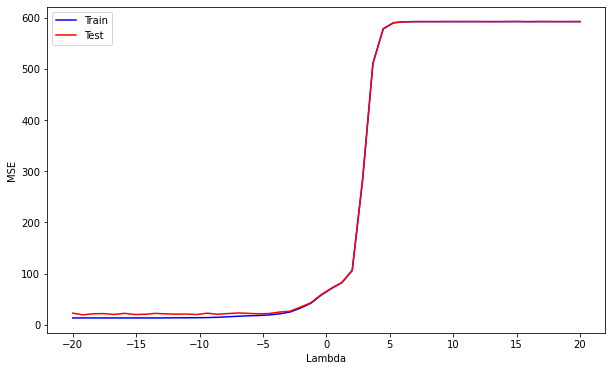

In [15]:
lambd = np.logspace(-20, 20, 50)

folds = 8
kf = KFold(n_splits=folds,shuffle=True)

MSE_test_lambda_kfold = []
MSE_train_lambda_kfold = []
r2_test_lambda_kfold = []
r2_train_lambda_kfold = []

X_cv = DesignMatrix(2,X)

for L in lambd:
    
    MSE_tests_kfold = np.zeros(folds)
    MSE_trains_kfold = np.zeros(folds)
    r2_tests_kfold = np.zeros(folds)
    r2_trains_kfold = np.zeros(folds)
    
    itr = 0
    for train_i, test_i in kf.split(X_cv):

        X_train, X_test, y_train, y_test = X_cv[train_i], X_cv[test_i], y_cv[train_i], y_cv[test_i]
        Ridge = Regressor("Ridge", X_train, X_test, y_train, y_test, L)

        MSE_tests_kfold[itr] = Ridge.MSE_test()
        MSE_trains_kfold[itr] = Ridge.MSE_train()
        r2_tests_kfold[itr] = Ridge.r2score_test()
        r2_trains_kfold[itr] = Ridge.r2score_train()
        itr +=1

    MSE_test_lambda_kfold.append( np.mean(MSE_tests_kfold) )
    MSE_train_lambda_kfold.append( np.mean(MSE_trains_kfold) )
    r2_test_lambda_kfold.append( np.mean(r2_tests_kfold) )
    r2_train_lambda_kfold.append( np.mean(r2_trains_kfold) )

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(np.log10(lambd), MSE_train_lambda_kfold, color = 'blue', label = 'Train')
ax.plot(np.log10(lambd), MSE_test_lambda_kfold, color = 'red', label = 'Test')
ax.set_xlabel('Lambda')
ax.set_ylabel('MSE')
ax.legend()
plt.show()

#### $\lambda$ optimization and results from Ridge

In [16]:
Opt_lambda = lambd[np.where(MSE_test_lambda==np.min(MSE_test_lambda))][0]
Opt_lambda_bootstrap = lambd[np.where(MSE_test_lambda_bootstrap==np.min(MSE_test_lambda_bootstrap))][0]
Opt_lambda_kfold = lambd[np.where(MSE_test_lambda_kfold==np.min(MSE_test_lambda_kfold))][0]

print("Optimal penalizer value (no resampling):", Opt_lambda)
print("Optimal penalizer value (bootstrap):", Opt_lambda_bootstrap)
print("Optimal penalizer value (kfold):", Opt_lambda_kfold, "\n")

print(f"MSE (no resampling, optimal lambda: {Opt_lambda}): {np.min(MSE_test_lambda)}")
print(f"MSE (bootstrap, optimal lambda: {Opt_lambda_bootstrap}): {np.min(MSE_test_lambda_bootstrap)}")
print(f"MSE (kfold, optimal lambda: {Opt_lambda_kfold}): {np.min(MSE_test_lambda_kfold)}")

Optimal penalizer value (no resampling): 3.2374575428176535e-05
Optimal penalizer value (bootstrap): 4.941713361323839e-06
Optimal penalizer value (kfold): 6.551285568595496e-20 

MSE (no resampling, optimal lambda: 3.2374575428176535e-05): 19.91280501116621
MSE (bootstrap, optimal lambda: 4.941713361323839e-06): 21.091248520412627
MSE (kfold, optimal lambda: 6.551285568595496e-20): 19.331936512407907


### Ridge: no resampling vs bootstrap vs cross-validation

In [17]:
print("MSE (no resampling):", np.round(np.min(MSE_test_lambda),3) )
print("R2 score (no resampling):", np.round(R2_test_lambda[np.where(MSE_test_lambda==np.min(MSE_test_lambda))[0][0]],3), "\n")  

print("MSE (bootstrap):", np.round(np.min(MSE_test_lambda_bootstrap),3) )
print("R2 score (bootstrap):", np.round(R2_test_lambda_bootstrap[np.where(MSE_test_lambda==np.min(MSE_test_lambda))[0][0]],3), "\n")  

print("MSE (kfold):", np.round(np.min(MSE_test_lambda_kfold),3) )
print("R2 score (kfold):", np.round(r2_test_lambda_kfold[np.where(MSE_test_lambda==np.min(MSE_test_lambda))[0][0]],3) )  

MSE (no resampling): 19.913
R2 score (no resampling): 0.777 

MSE (bootstrap): 21.091
R2 score (bootstrap): 0.722 

MSE (kfold): 19.332
R2 score (kfold): 0.731


## Conclusions

From a whole rundown of the obtained final results from each combination of regression method and resampling technique, we can draw some final conclusions. First of all, we can observe that OLS regression always gives better results when performed without a resampling technique. This is problematic, because it makes the final results very unstable, and high variation have been observed when performing different runs due to the random nature of the data selection.

That leaves us with the **Ridge regression model**, that generally shows better results through the different resampling thechniques than the OLS, and seems to work better when using them. In particular, the best results are normally obtained when combining this method with **cross-validation resampling**, therefore we can conclude that this combination is the most adequate of the one we have studied.

Finally, we would like to mention that the dataset we are fitting depends initially on 13 parameters and we have studied the correlation between all of them and also, the correlation with the data we want to fit. Even though we discarded some of them in order to provide the most general model, we consider that some information could be lost while doing so.